In [ ]:
import datetime as dt
from datetime import datetime
import numpy as np
import math
import pandas as pd 
from pandas_datareader import DataReader
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
periodo = {'diario' : 1, 'semanal' : 7, 'mensual': 30}

moneda = input('Ingrese moneda a predecir (BTC-USD,DCR-USD,ETH-USD):')
window = input('Ingrese periodo de tiempo (diario, semanal, mensual):')

Ingrese moneda a predecir (BTC-USD,DCR-USD,ETH-USD): BTC-USD
Ingrese periodo de tiempo (diario, semanal, mensual): diario


In [3]:
cripto_m = DataReader(str(moneda), "yahoo")
rolling = cripto_m['Close'].rolling(window = periodo[window])    
cripto_MA = rolling.mean()
cripto_MA = cripto_MA[-(32*32):]

In [38]:
lista = np.array(np.log(cripto_MA))
fecha = np.arange(1,len(lista)+1)
window_e = 10
count = 0.0
dataset_RMSEE = pd.DataFrame()
merged_data_RMSEE = pd.DataFrame()
for i in range(0, len(lista)):
    for j in range(i,(window_e+i)):
        count += -1 * (lista[j] * math.log(lista[j]))
        
    dataset_RMSEE = np.array((count)*(1/window_e))
    dataset_RMSEE = pd.DataFrame(dataset_RMSEE.reshape(1,1))
    dataset_RMSEE.index = [fecha[i]]
    merged_data_RMSEE = merged_data_RMSEE.append(dataset_RMSEE)
    count = 0
    if(i == (len(lista)-window_e)):
        break
        
merged_data_RMSEE.columns = ['Close']
no_clusters = 3
kmeans = KMeans(n_clusters = no_clusters, random_state=170).fit(np.array(merged_data_RMSEE))

def k_means(data, no_clusters):
    kmeans = KMeans(n_clusters=no_clusters, random_state=170).fit(np.array(data))
    data2 = data.copy()
    data2["clusters"] = kmeans.labels_
    data2["nombre"] = "Cluster"

    data2["clusters"] = data2["nombre"].astype(str) + " " + data2["clusters"].astype(str)
    data2 = data2.drop(['nombre'], axis=1)
    return data2

k_m = k_means(merged_data_RMSEE, no_clusters)

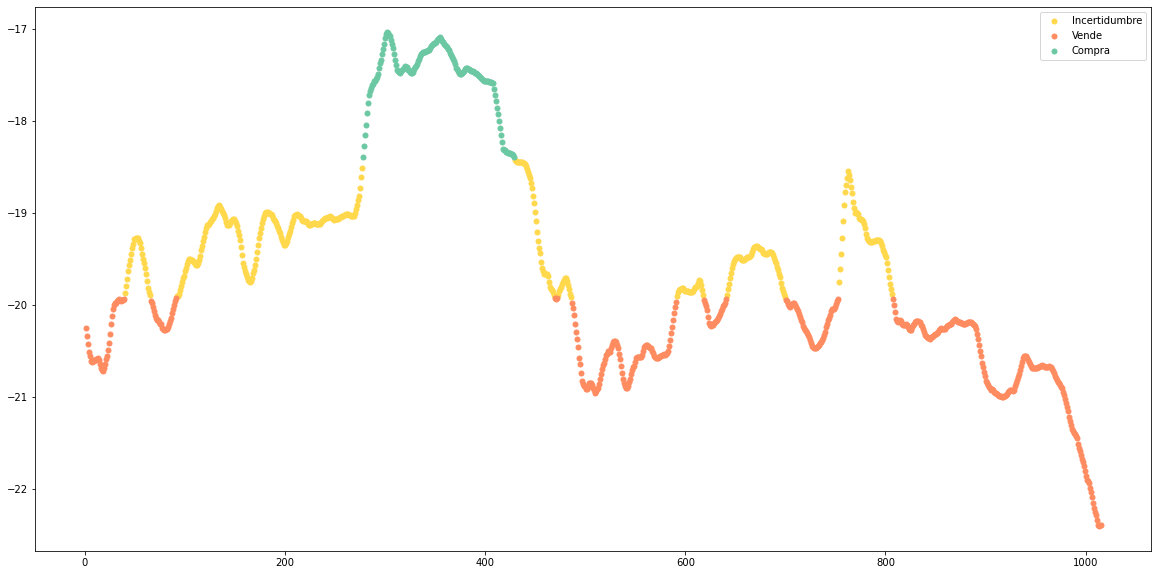

In [39]:
df = pd.DataFrame(dict(x = k_m.index, y=k_m['Close'], label=k_m['clusters']))
n_cluster = np.zeros(3)
groups = df.groupby('label')

for label in df['label']:
    if (label == 'Cluster 0'):
        n_cluster[0] += 1
    elif (label == 'Cluster 1'):
        n_cluster[1] += 1
    else:
        n_cluster[2] += 1
        
#etiqueta = { 9 : 'Compra',2 : 'Compra',4 : 'Compra', 7: 'Incertidumbre',0: 'Incertidumbre',8: 'Incertidumbre',3: 'Incertidumbre', 5 : 'Vende',1 : 'Vende',6 : 'Vende'}        
etiqueta = {0 : 'Incertidumbre', 1 : 'Vende', 2 : 'Compra'}
color = {0 : '#FFD84C',1 : '#FF8B60',2 : '#6BC8A3'}

fig, ax = plt.subplots()
for name, group in groups:
    if(name == 'Cluster 1'):#  or name == 'Cluster 5' or name == 'Cluster 6'):
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label='Vende', color = '#FF8B60')
    elif(name == 'Cluster 0'):#  or name == 'Cluster 7' or name == 'Cluster 8' or name == 'Cluster 3'):
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label='Incertidumbre', color = '#FFD84C')
    elif(name == 'Cluster 2'):#  or name == 'Cluster 9' or name == 'Cluster 4'):
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label='Compra', color = '#6BC8A3')
ax.legend()
plt.show()

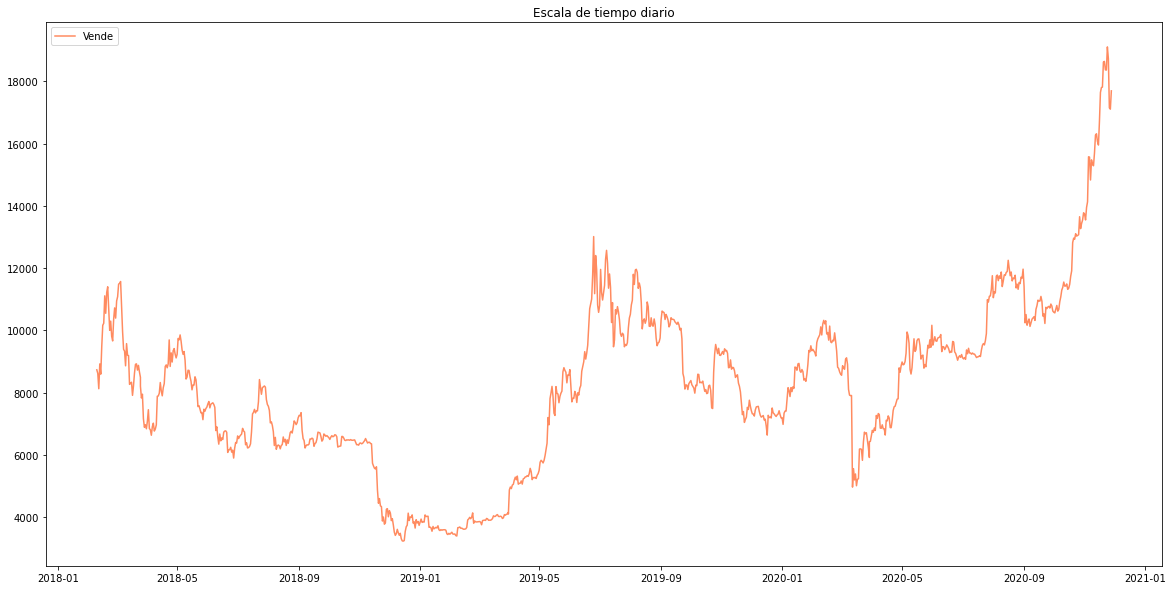

In [50]:
plt.title('Escala de tiempo '+str(window))
graph, = plt.plot(cripto_MA, color = color[np.argmax(n_cluster)],label = etiqueta[np.argmax(n_cluster)])
plt.legend(handles=[graph],loc='upper left')
plt.show()

In [17]:
from PIL import Image
def img():
    tam = 32
    dataset = np.log(cripto_MA)
    data_img = dataset
    mini = min(data_img)
    maxi = max(data_img)
    x = 0 
    y = 0
    df = np.zeros((tam, tam)).astype(np.uint8)
    for k in range(len(dataset)):
        df[y][x] = round((data_img[k] - mini) / (maxi - mini)*255)
        x+=1
        if(x == tam):
            y+=1
            x = 0
            
    img = Image.fromarray(df)
   
    
    
    return img

In [18]:
model = tf.keras.models.load_model('CNN_BTC_'+str(periodo[window])+'.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       36992     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

In [49]:
imagen = img()
#plt.imshow(imagen, cmap=plt.cm.binary)
imagen = np.asarray(imagen).reshape(-1,32,32,1)

class_names = ['incertidumbre', 'VENDER', 'comprar','incertidumbre tendiendo a vender','COMPRAR','vender','V E N D E R','incertidumbre tendiendo a comprar','incertidumbre','C O M P R A R']
predictions = model.predict(imagen)
score = tf.nn.softmax(predictions[0])

print(
    "Deberias tomar la decición de \033[1m {} \033[0m con un {:.2f} por ciento de confianza."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Deberias tomar la decición de  incertidumbre tendiendo a vender  con un 100.00 por ciento de confianza.
